# Predicting Depression Among Students using Stacking Ensemble Techniques

by Blaise Andrei Geronimo

# Introduction


In recent years, the mental health crisis among Filipino students has become a growing public concern. Data from the Commission on Higher Education (CHED) revealed that mental health issues have overtaken academic difficulty as one of the top reasons for college attrition in the Philippines. In fact, CHED Chairperson Prospero de Vera noted that mental health concerns now rank fourth among the top five reasons students discontinue their studies, higher than academic performance itself, which only placed fifth. In some regions, attrition rates soared to over 90% at the height of the pandemic, with mental well-being emerging as an "unexpected but critical" factor in student dropout trends (Bordey, 2024).

This issue is not confined to higher education. According to the Department of Education (DepEd), 404 public school learners committed suicide in 2021, while over 2,100 attempted suicide and nearly 776,000 students sought counseling. These numbers underscore an urgent reality: the Philippine education system is facing a mental health crisis that affects both learning outcomes and life outcomes (Felipe, 2023).

Despite this alarming situation, there remains a stark shortage of guidance counselors, with a national average ratio of 1 counselor per 13,394 students, far from the recommended 1:250. In many institutions, systemic gaps in support services leave students undiagnosed, unmonitored, and untreated. Meanwhile, administrative limitations and lack of career progression discourage professionals from staying in mental health roles within schools.

Given these realities, early identification of depressive symptoms using scalable, data-driven tools becomes not only a technical challenge but a societal imperative. Accurate prediction models can help detect at-risk students before their mental health deteriorates further, enabling timely interventions, improving academic retention, and potentially saving lives. In a country where access to psychological care remains limited, especially in rural or underserved areas, machine learning models offer a cost-effective and scalable approach to support mental health screening.

This study, therefore, investigates the potential of stacking ensemble models to predict depression among students using behavioral and psychosocial data. Grounded in methods proven effective in prior studies and adapted to the Philippine educational context, this approach aims to contribute not only to the data science field but to the broader advocacy of student well-being and educational equity.

# Method

This study presents a supervised machine learning approach to predict depression among students using a publicly available dataset sourced from Kaggle, originally compiled by Shamim (2025). The central modeling strategy was a stacking ensemble classifier, which combined multiple base learners with high-performing meta-learners, as inspired by Vergaray et al. (2023)

## Dataset

The dataset comprises 22 columns including the target variable (Depression) and 21 features such as:
* **Demographics**: Age, Gender
* **Lifestyle**: Sleep duration, Financial support, GPA, Time spent on study
* **Psychosocial indicators**: Social media usage, Family history of mental illness, Suicidal thoughts, and Academic performance satisfaction

These features are also seen to be relevant in the literature as risk factors for mental health issues in young adults.

## Data Preprocessing

Data preprocessing steps involved handling missing values, label encoding for categorical responses, and standardization of numerical features. Oversampling techniques were applied to balance class distribution and prevent model bias toward majority classes. Feature normalization was performed using standard scaling, consistent with approaches recommended in Vu et al. (2025) and Iparraguirre-Villanueva et al. (2024)

## Model Architecture

Three widely used base models were selected due to their consistent performance across depression-related prediction tasks in recent studies: Support Vector Machines (SVM), K-Nearest Neighbors (KNN), and Naïve Bayes (NB) (Gil et al., 2022; Choudhury et al., 2019). These were used as level-0 learners to capture different decision boundaries and probabilistic behaviors. Their outputs were then fed into various level-1 meta-learners: Logistic Regression (LR), Random Forest (RF), and XGBoost, inspired by their dominance in ensemble-based depression prediction studies (Vu et al., 2025; Vergaray et al., 2023)

## Evaluation

Model performance was assessed using stratified k-fold cross-validation to ensure robustness across class distributions. The evaluation metrics included accuracy, precision, recall, F1-score, and ROC-AUC, in line with metrics used in comparable literature. To better understand model behavior, interpretability techniques such as SHAP (SHapley Additive Explanations) were optionally explored for tree-based models. In addition to cross-validation, model performance was also evaluated on a separate test set to provide an unbiased assessment of generalization performance.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import random
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, roc_auc_score
from sklearn.inspection import permutation_importance

C:\Users\Blaise Geronimo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 16
random.seed(SEED)

# Data Loading

In [3]:
df = pd.read_csv('student_depression_dataset.csv')
df

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33,Visakhapatnam,Student,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1
1,8,Female,24,Bangalore,Student,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0
2,26,Male,31,Srinagar,Student,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0
3,30,Female,28,Varanasi,Student,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1
4,32,Female,25,Jaipur,Student,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27,Surat,Student,5,0,5.75,5,0,'5-6 hours',Unhealthy,'Class 12',Yes,7,1,Yes,0
27897,140686,Male,27,Ludhiana,Student,2,0,9.40,3,0,'Less than 5 hours',Healthy,MSc,No,0,3,Yes,0
27898,140689,Male,31,Faridabad,Student,3,0,6.61,4,0,'5-6 hours',Unhealthy,MD,No,12,2,No,0
27899,140690,Female,18,Ludhiana,Student,5,0,6.88,2,0,'Less than 5 hours',Healthy,'Class 12',Yes,10,5,No,1


### Data Dictionary

| **Variable Name**                     | **Description**                                                     | **Data Type**     |
|--------------------------------------|---------------------------------------------------------------------|-------------------|
| `id`                                 | A unique identifier assigned to each student record in the dataset. | Integer           |
| `Gender`                             | The gender of the student (e.g., Male, Female, Other).              | Categorical       |
| `Age`                                | The age of the student in years.                                    | Integer           |
| `City`                               | The city or region where the student resides.                       | Categorical       |
| `Profession`                         | The field of work or study of the student.                          | Categorical       |
| `Academic Pressure`                  | Level of pressure in academic settings.                             | Numeric (Ordinal) |
| `Work Pressure`                      | Level of pressure from work or job responsibilities.                | Numeric (Ordinal) |
| `CGPA`                               | Cumulative Grade Point Average.                                     | Float             |
| `Study Satisfaction`                 | Satisfaction level with their studies.                              | Numeric (Ordinal) |
| `Job Satisfaction`                   | Satisfaction level with their job.                                  | Numeric (Ordinal) |
| `Sleep Duration`                     | Average number of hours of sleep per day.                           | Categorical       |
| `Dietary Habits`                     | Assessment of eating patterns and nutrition.                        | Categorical       |
| `Degree`                             | Academic degree or program being pursued.                           | Categorical       |
| `Have you ever had suicidal thoughts ?` | Whether the student has experienced suicidal ideation (Yes/No).     | Boolean           |
| `Work/Study Hours`                   | Average number of hours per day spent on work or study.             | Float             |
| `Financial Stress`                   | Level of stress due to financial concerns.                          | Numeric (Ordinal) |
| `Family History of Mental Illness`   | Whether there is a family history of mental illness (Yes/No).       | Boolean           |
| `Depression`                         | Indicates if the student is experiencing depression (Yes: 1/No: 0). | Boolean (Target)  |


In [4]:
df = df.drop(columns=['id'], axis=1)

In [5]:
df.rename(columns={'Have you ever had suicidal thoughts ?': 'Suicidal Thoughts'}, inplace=True)

In [6]:
cat_cols = [
    'Gender',
    'City',
    'Profession',
    'Academic Pressure',
    'Work Pressure',
    'Study Satisfaction',
    'Job Satisfaction',
    'Dietary Habits',
    'Degree',
    'Suicidal Thoughts',
    'Family History of Mental Illness',
    'Financial Stress',
    'Depression',
    'Sleep Duration'
]

df[cat_cols] = df[cat_cols].astype('category')

# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Gender                            27901 non-null  category
 1   Age                               27901 non-null  int64   
 2   City                              27901 non-null  category
 3   Profession                        27901 non-null  category
 4   Academic Pressure                 27901 non-null  category
 5   Work Pressure                     27901 non-null  category
 6   CGPA                              27901 non-null  float64 
 7   Study Satisfaction                27901 non-null  category
 8   Job Satisfaction                  27901 non-null  category
 9   Sleep Duration                    27901 non-null  category
 10  Dietary Habits                    27901 non-null  category
 11  Degree                            27901 non-null  cate

In [8]:
df.describe()

,Age,CGPA,Work/Study Hours
count,27901.000000,27901.000000,27901.000000
mean,25.822300,7.656104,7.156984
std,4.905687,1.470707,3.707642
min,18.000000,0.000000,0.000000
25%,21.000000,6.290000,4.000000
50%,25.000000,7.770000,8.000000
75%,30.000000,8.920000,10.000000
max,59.000000,10.000000,12.000000


In [9]:
print(df.isnull().sum())

Gender                              0
Age                                 0
City                                0
Profession                          0
Academic Pressure                   0
Work Pressure                       0
CGPA                                0
Study Satisfaction                  0
Job Satisfaction                    0
Sleep Duration                      0
Dietary Habits                      0
Degree                              0
Suicidal Thoughts                   0
Work/Study Hours                    0
Financial Stress                    0
Family History of Mental Illness    0
Depression                          0
dtype: int64


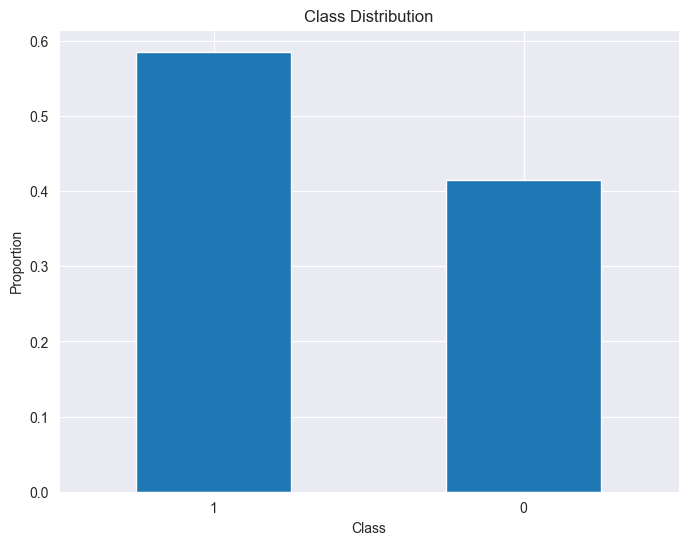

In [10]:
plt.figure(figsize=(8, 6))
df['Depression'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.ylabel('Proportion')
plt.show()

The class distribution plot reveals a slight imbalance in the dataset, with approximately most of the students labeled as experiencing depression (class 1), while the remaining are not (class 0). Although the imbalance is not extreme, it is still notable and should be taken into account during model evaluation. Relying solely on accuracy may be misleading in such cases, so it is important to also consider other metrics like precision, recall, and ROC-AUC to ensure that the model performs well across both classes. This distribution also reflects a significant prevalence of depression among the student population, highlighting the relevance and urgency of the study.

## Categorical Variables

In [11]:
# to check cardinality
print(df[cat_cols].nunique())

Gender                               2
City                                52
Profession                          14
Academic Pressure                    6
Work Pressure                        3
Study Satisfaction                   6
Job Satisfaction                     5
Dietary Habits                       4
Degree                              28
Suicidal Thoughts                    2
Family History of Mental Illness     2
Financial Stress                     6
Depression                           2
Sleep Duration                       5
dtype: int64


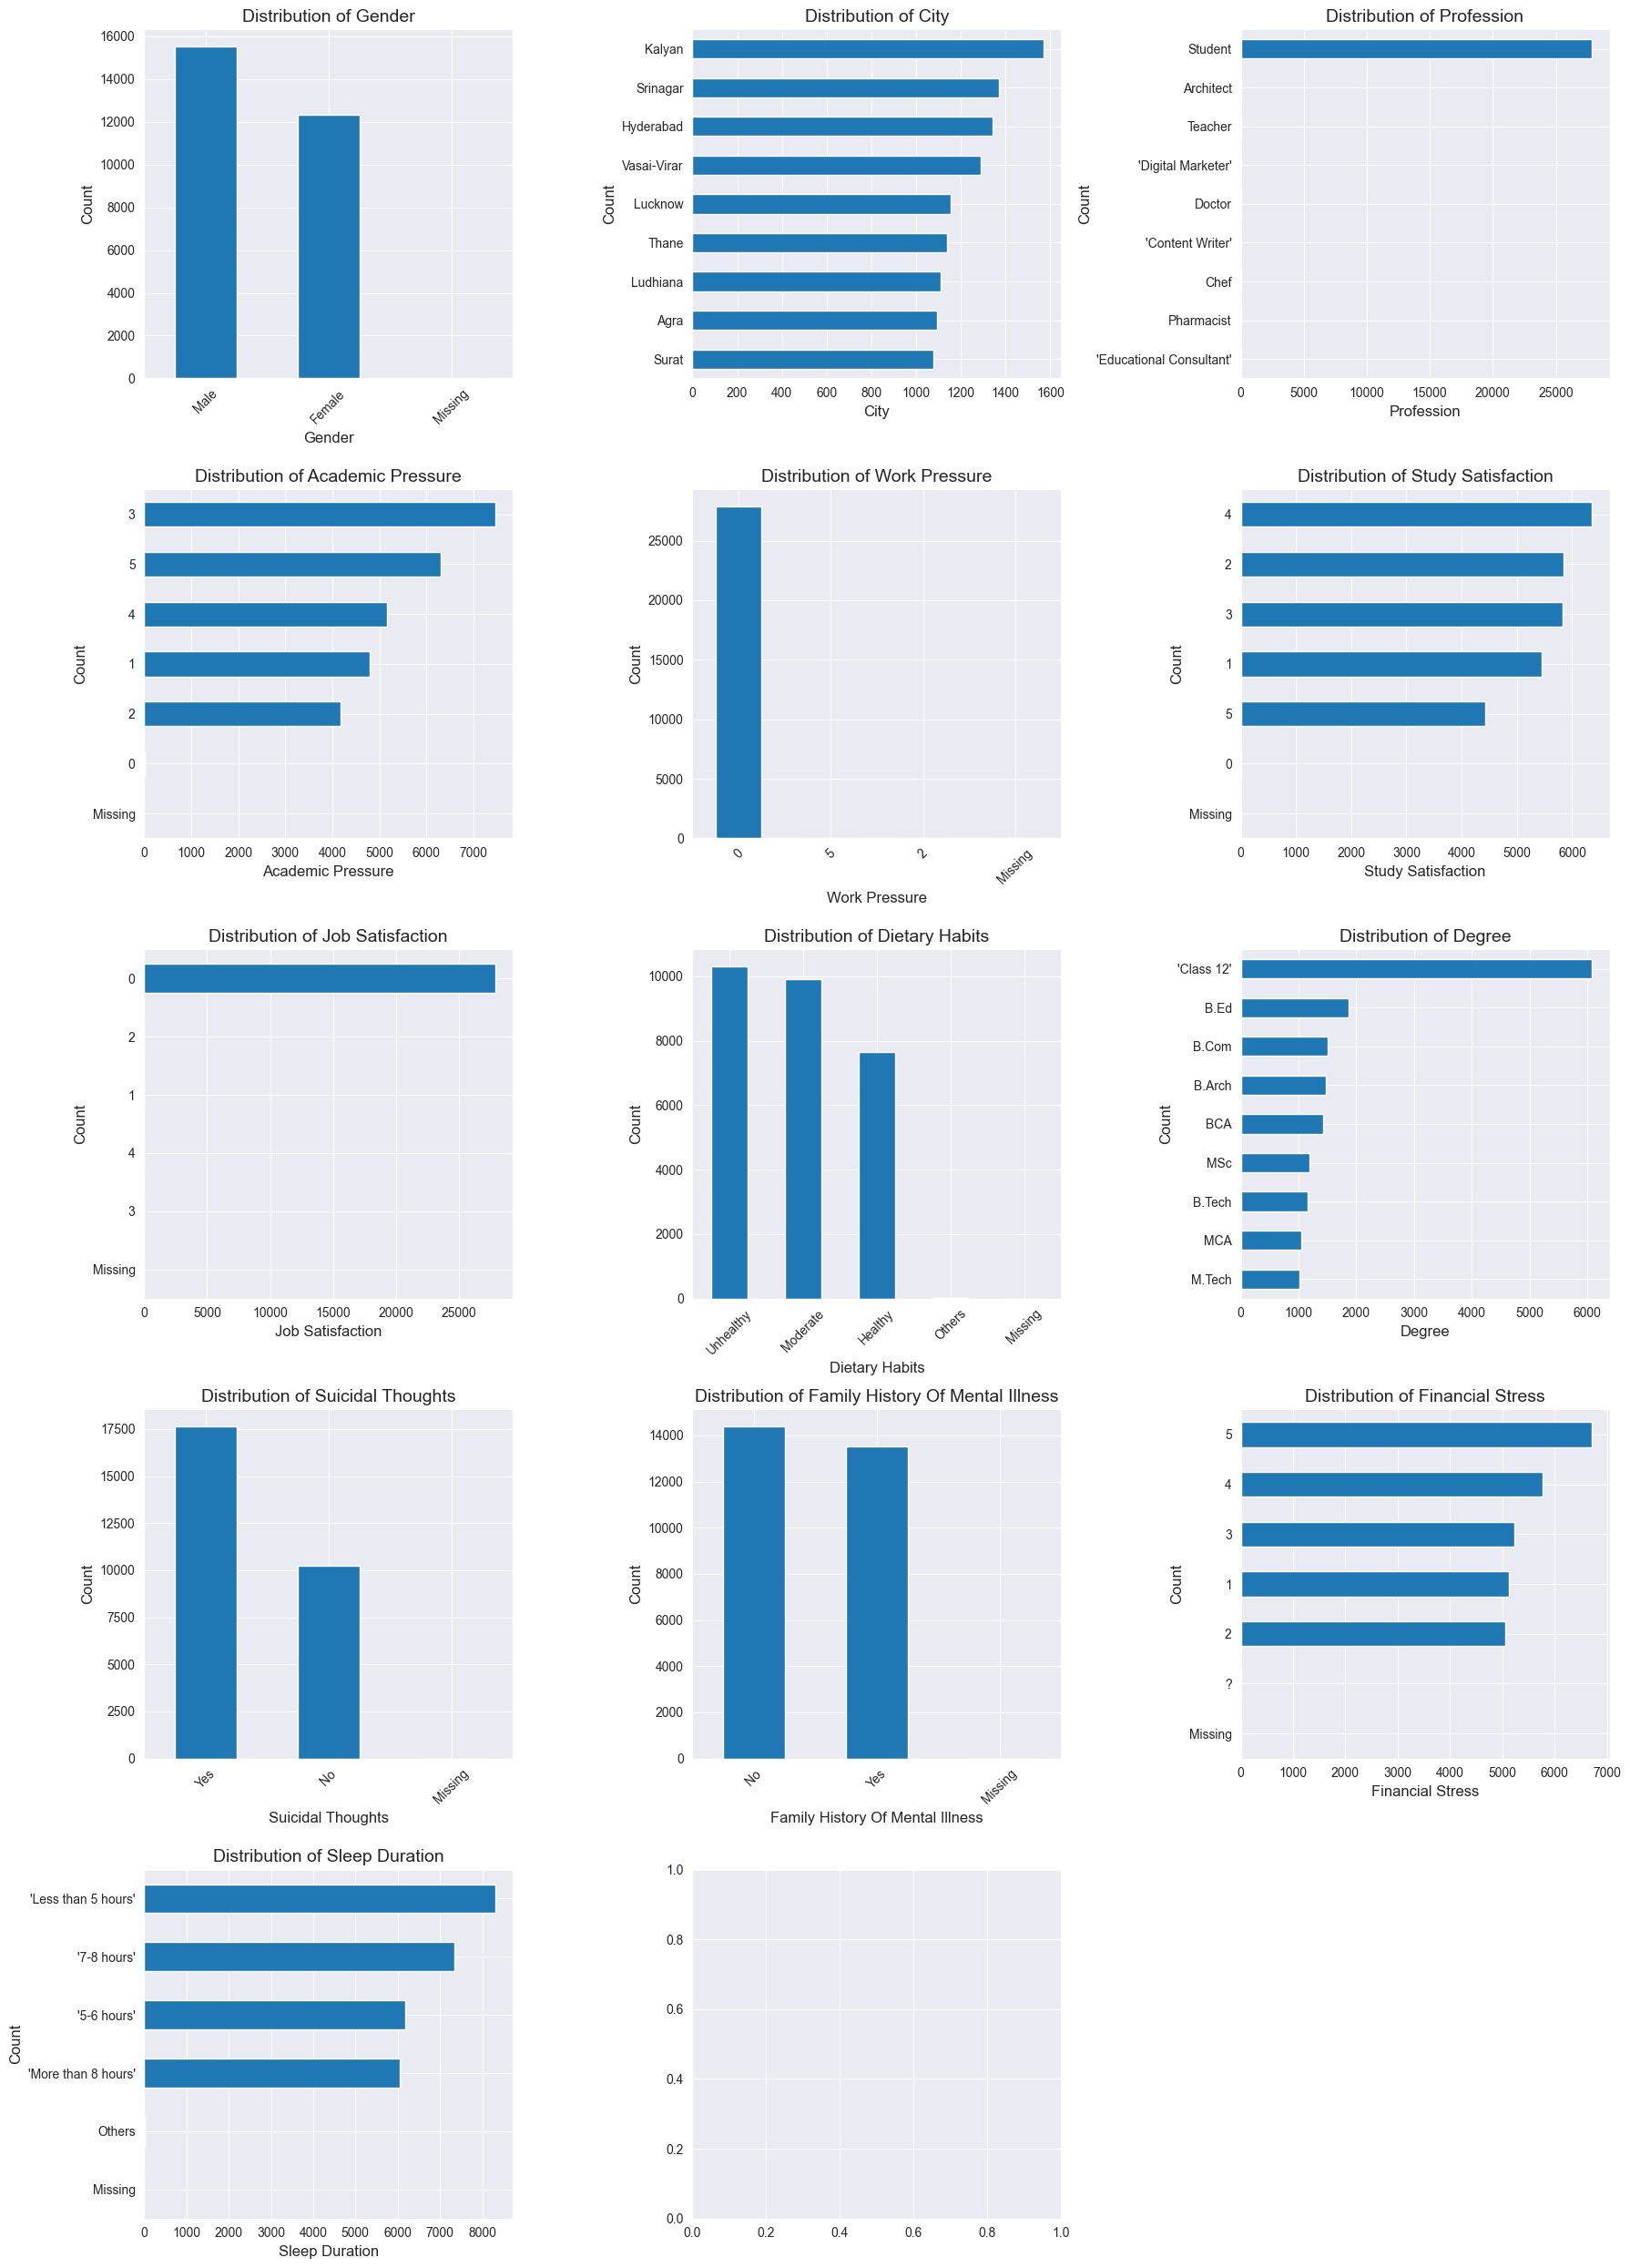

In [12]:
cat_cols_no_target = [col for col in cat_cols if col != 'Depression']
n_cols = 3
n_rows = -(-len(cat_cols_no_target) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = np.atleast_1d(axes).flatten()

TOP_N = 9  # how many categories to keep

for idx, col in enumerate(cat_cols_no_target):
    # Correct Categorical type checking
    if isinstance(df[col].dtype, pd.CategoricalDtype):
        if 'Missing' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('Missing')

    temp_series = df[col].fillna('Missing')
    vc = temp_series.value_counts()
    value_counts = vc.iloc[:TOP_N]  # ONLY keep top N

    # Plotting
    if len(value_counts) > 5:  # more than 5 -> horizontal barh
        value_counts.sort_values(ascending=True).plot(kind='barh', ax=axes[idx])
    else:  # 5 or fewer -> vertical bar
        value_counts.plot(kind='bar', ax=axes[idx])

    axes[idx].set_title(f'Distribution of {col.title()}', fontsize=14)
    axes[idx].set_xlabel(col.title(), fontsize=12)
    axes[idx].set_ylabel('Count', fontsize=12)

    # Apply x-tick rotation if more than 5 x-ticks
    if len(value_counts) > 5:
        axes[idx].tick_params(axis='y', rotation=0)  # y-axis labels for barh
    else:
        axes[idx].tick_params(axis='x', rotation=45)  # x-axis labels for bar

# Remove unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

These bar graphs provide further insight into the characteristics of the student population studied. The gender distribution remains fairly balanced, with a slight male majority. The most common cities of residence include Kalyan, Srinagar, and Hyderabad, reflecting urban diversity. Unsurprisingly, the majority identify as students, consistent with the study's focus.

Academic pressure levels 3 and 5 dominate, suggesting moderate to high perceived pressure. Interestingly, work pressure is overwhelmingly low for most respondents, which may indicate that many are not engaged in part-time jobs or employment. In contrast, study satisfaction appears relatively spread out, though level 4 satisfaction is most common. Job satisfaction is heavily skewed toward level 0, which may indicate a lack of job experience among students.

Dietary habits lean toward "healthy" and "moderate," while degrees are mostly from secondary education (Class 12) or undergraduate programs, aligning with typical student profiles. A concerning number of students report having experienced suicidal thoughts, emphasizing the mental health burden. Additionally, nearly half report a family history of mental illness.

Financial stress levels are widely distributed, with level 5 (highest stress) being the most common. Lastly, sleep duration trends show that a large number of students sleep less than five hours per night, which may be a critical factor associated with mental health outcomes. These patterns highlight important behavioral, academic, and psychological contexts that can influence depression prediction models.

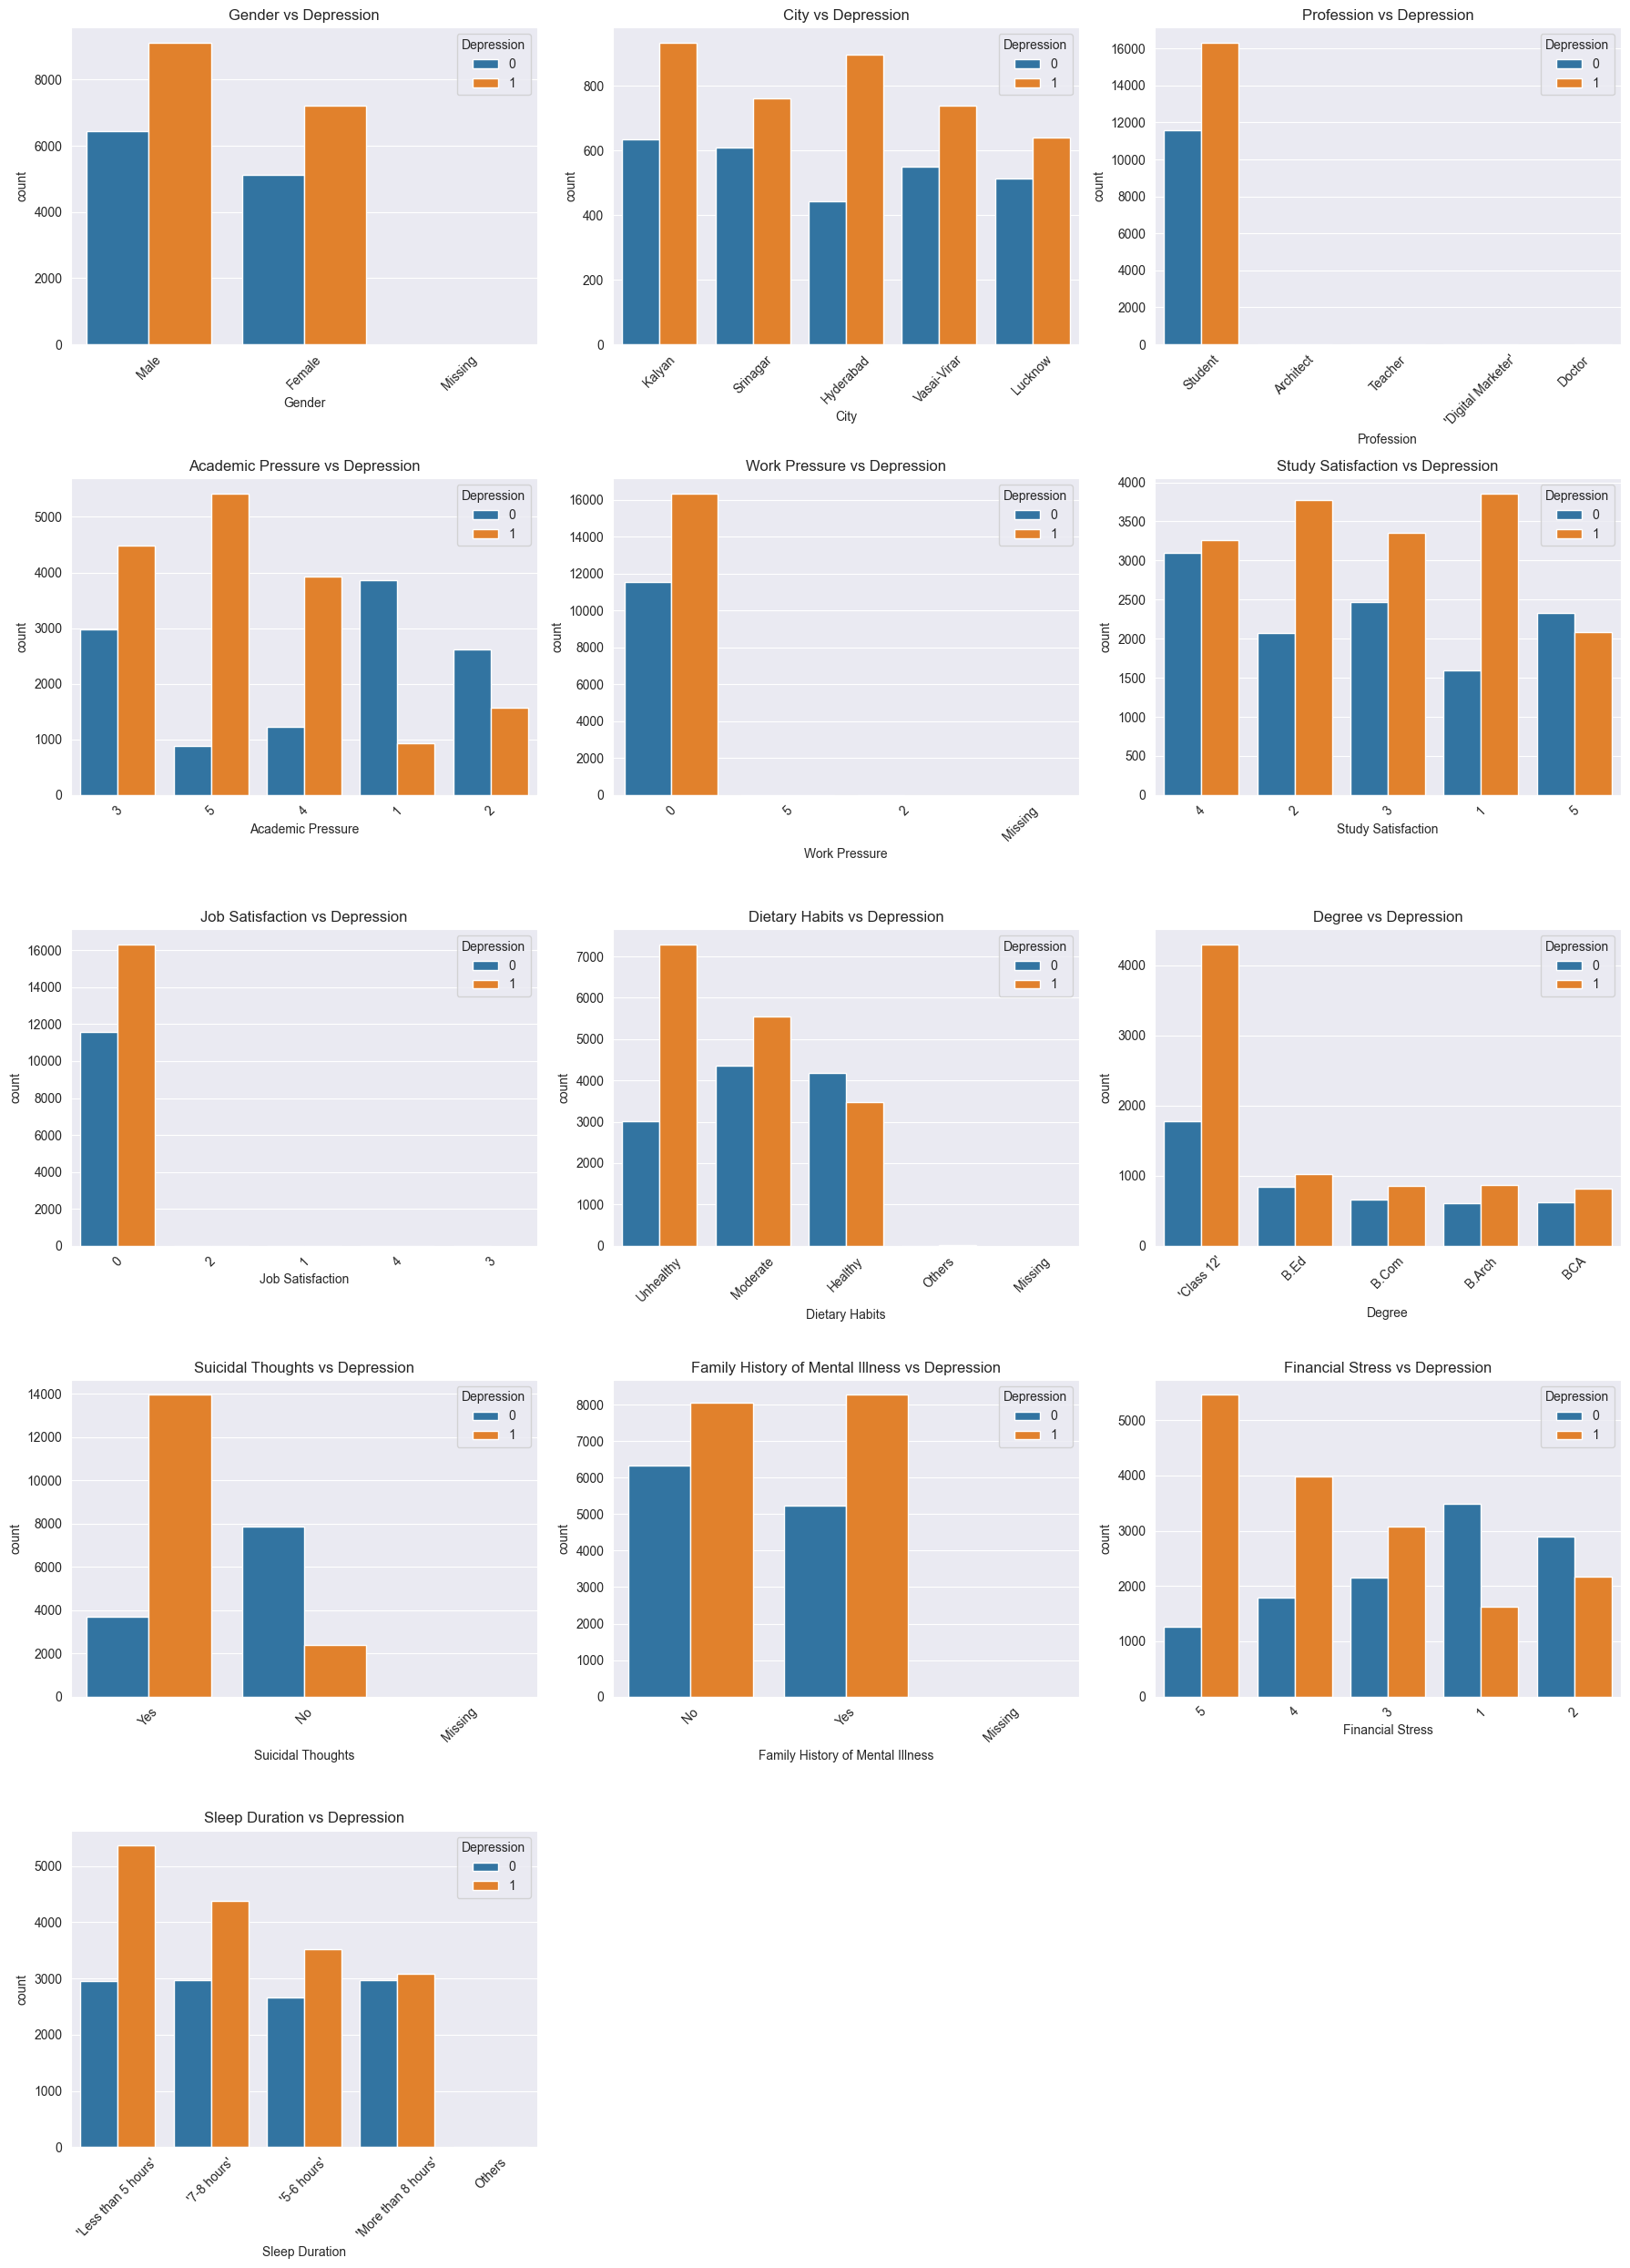

In [13]:
n_cols = 3
n_rows = -(-len(cat_cols_no_target) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

TOP_N = 5

for idx, col in enumerate(cat_cols_no_target):
    # Remove missing first
    temp_series = df[col].fillna('Missing')

    # Get top N categories (total across all Depression groups)
    top_categories = temp_series.value_counts().head(TOP_N).index

    # Filter only Top N
    filtered_df = df[df[col].isin(top_categories)]

    # Set category order manually for cleaner x-axis
    order = top_categories

    # Plot
    sns.countplot(data=filtered_df, x=col, hue='Depression', ax=axes[idx], order=order)
    axes[idx].set_title(f'{col} vs Depression')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove unused subplots
for i in range(len(cat_cols_no_target), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

These bivariate plots offer valuable insights into how different features relate to the presence of depression among students. Several patterns emerge:

**Gender vs Depression:** \
Depression is slightly more common among female students than males, though both groups show substantial cases.

**City vs Depression:** \
Across the top cities, those with depression (class 1) consistently outnumber those without, indicating geographic uniformity in depression prevalence.

**Academic Pressure:** \
Higher academic pressure levels (3 and 5) are associated with more cases of depression, suggesting that moderate to high academic stress may be a significant risk factor.

**Work Pressure:** \
Most students report no work pressure, but among those who do experience it, the rate of depression is noticeably higher.

**Study Satisfaction and Job Satisfaction:** \
Lower satisfaction levels correlate with higher depression counts, particularly where study satisfaction is rated 2 or below and job satisfaction is minimal.

**Dietary Habits:** \
Students with unhealthy or moderate dietary habits report more depression cases than those with healthy habits, supporting the link between nutrition and mental health.

**Degree Level:** \
Depression is more prevalent among students in early education levels (e.g., Class 12), potentially reflecting increased vulnerability during transition periods.

**Suicidal Thoughts:** \
A very strong correlation is observed, those who reported suicidal ideation are significantly more likely to also be depressed.

**Family History of Mental Illness:** \
Students with a family history show a notably higher count of depression, highlighting a possible genetic or environmental predisposition.

**Financial Stress:** \
Higher levels of financial stress (especially level 5) are strongly associated with depression, indicating its role as a major stressor.

**Sleep Duration:** \
Students who sleep less than 5 hours or 5–6 hours show more instances of depression, which might imply that sleep deprivation is a mental health risk.

## Numerical Variables

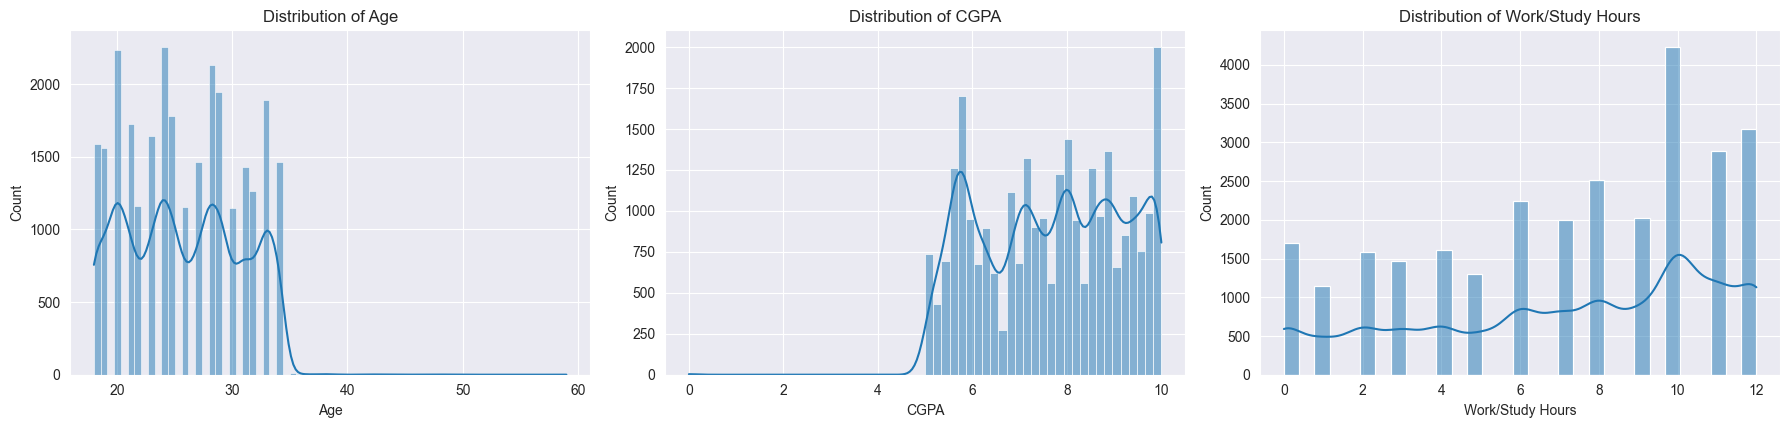

In [14]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Remove extra empty subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These plots display the distributions of three numerical features: Age, CGPA, and Work/Study Hours, offering key insights into their spread and shape.
* `Age` is right-skewed, with most students between 18 and 35 years old—reflecting the typical college and postgraduate demographic. There’s a sharp drop-off beyond the early 30s, which aligns with the dataset’s focus on student populations.
* `CGPA` distribution is roughly uniform between 5.0 and 10.0, with mild peaks near 6.0, 8.0, and 10.0. This suggests a wide academic performance range among students, without extreme skewness or clustering at any single point.
* `Work/Study Hours` shows higher frequency at values 6, 8, 10, and 12—likely influenced by common class schedules or study routines. There’s no strong skew, though we observe some peaks at practical thresholds (e.g., 10+ hours).

Although these variables are not perfectly normally distributed, transformation is not essential in this context. That’s because the models used in the study—Logistic Regression (as a meta learner), Random Forest, XGBoost, SVM, and k-NN, are distribution-agnostic. Tree-based models (RF, XGBoost) and SVMs do not require normally distributed inputs, and Logistic Regression, when used in a stacking ensemble, relies more on learned relationships from well-scaled data than strict distributional assumptions. Additionally, MinMax scaling will be applied, to ensure all numeric features lie within the same range, which is particularly important for models like k-NN and SVM that are sensitive to scale. Thus, transformation to normality is not needed and may even reduce interpretability in this case.

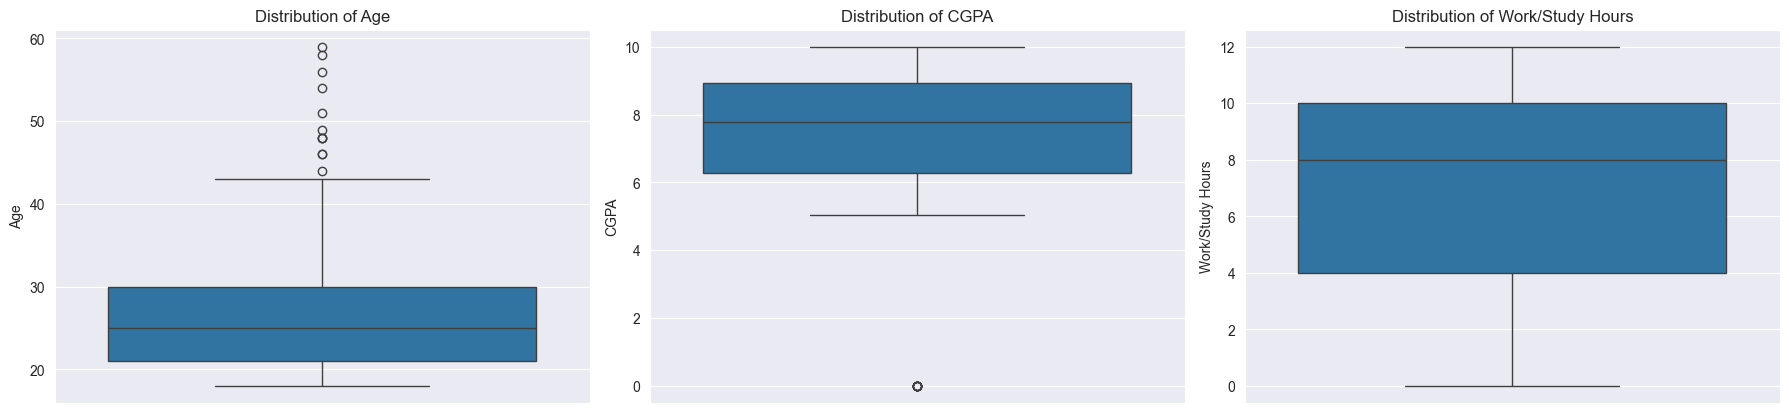

In [15]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Remove extra empty subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These boxplots show the spread and presence of outliers in three key numerical features: `Age`, `CGPA`, and `Work/Study Hours`.
* `Age` shows a fairly compact interquartile range (IQR) centered around 22–30 years, which aligns with a typical student demographic. A few outliers extend beyond 40 and up to nearly 60 years old. However, given the educational context, these could be valid mature students or nontraditional learners rather than data entry errors.
* `CGPA` values are mostly between 6.0 and 9.5, with a very small number of outliers—including some near-zero values. These might represent invalid entries or exceptional academic cases, but they are extremely rare.
* `Work/Study Hours` has a broad range, with values from 0 to 12. The IQR is tight around 4 to 10 hours, which is expected for students. While the lower end includes some 0-hour entries, these could reflect breaks, minimal academic engagement, or reporting gaps.

While outliers are present in two of the three features, their proportion is extremely low relative to the full dataset size (27,000+ records). These rare points are unlikely to skew results, especially because the modeling pipeline involves distribution-agnostic machine learning models like Random Forest and XGBoost, which are robust to such variations. Furthermore, feature scaling via MinMax normalization will be applied to reduce their relative influence. Therefore, removal or transformation of these outliers is not strictly necessary for this analysis.

# Data Preprocessing

In [16]:
df.nunique()

Gender                                2
Age                                  34
City                                 52
Profession                           14
Academic Pressure                     6
Work Pressure                         3
CGPA                                332
Study Satisfaction                    6
Job Satisfaction                      5
Sleep Duration                        5
Dietary Habits                        4
Degree                               28
Suicidal Thoughts                     2
Work/Study Hours                     13
Financial Stress                      6
Family History of Mental Illness      2
Depression                            2
dtype: int64

## Data Cleaning

In [17]:
df_cleaned = df.copy()

### Categorical Columns

#### `Profession` column

In [18]:
df_cleaned['Profession'].value_counts()

Profession
Student                     27870
Architect                       8
Teacher                         6
'Digital Marketer'              3
Doctor                          2
Chef                            2
'Content Writer'                2
Pharmacist                      2
'Educational Consultant'        1
'Civil Engineer'                1
'UX/UI Designer'                1
Manager                         1
Lawyer                          1
Entrepreneur                    1
Missing                         0
Name: count, dtype: int64

Given that the project focuses on students, the DataFrame should be filtered to retain only student entries.

In [19]:
df_cleaned = df_cleaned[df_cleaned['Profession'] == 'Student']
df_cleaned = df_cleaned.drop(columns=['Profession'])  # safely drop because this only has 1 value now

#### `City` column

In [20]:
df_cleaned

,Gender,Age,City,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33,Visakhapatnam,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1
1,Female,24,Bangalore,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0
2,Male,31,Srinagar,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0
3,Female,28,Varanasi,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1
4,Female,25,Jaipur,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27,Surat,5,0,5.75,5,0,'5-6 hours',Unhealthy,'Class 12',Yes,7,1,Yes,0
27897,Male,27,Ludhiana,2,0,9.40,3,0,'Less than 5 hours',Healthy,MSc,No,0,3,Yes,0
27898,Male,31,Faridabad,3,0,6.61,4,0,'5-6 hours',Unhealthy,MD,No,12,2,No,0
27899,Female,18,Ludhiana,5,0,6.88,2,0,'Less than 5 hours',Healthy,'Class 12',Yes,10,5,No,1


In [21]:
df_cleaned['City'].unique()

['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur', ..., 'Nalyan', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad']
Length: 52
Categories (53, object): [''Less Delhi'', ''Less than 5 Kalyan'', '3', 'Agra', ..., 'Varanasi', 'Vasai-Virar', 'Visakhapatnam', 'Missing']

In [22]:
valid_cities = [
    'Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur', 'Pune', 'Thane',
    'Chennai', 'Nagpur', 'Nashik', 'Vadodara', 'Kalyan', 'Rajkot', 'Ahmedabad',
    'Kolkata', 'Mumbai', 'Lucknow', 'Indore', 'Surat', 'Ludhiana', 'Bhopal',
    'Meerut', 'Agra', 'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
    'Faridabad', 'Delhi'
]

In [23]:
def clean_city_name(city):
    city = str(city).strip()

    # Early cleaning: drop digits/special characters
    if not re.fullmatch(r"[A-Za-z\s\-']+", city):
        return np.nan

    # Normalize casing
    city_norm = city.title()

    # Exact match with whitelist
    if city_norm in valid_cities:
        return city_norm

    return np.nan

df_cleaned['City'] = df_cleaned['City'].apply(clean_city_name)
df_cleaned = df_cleaned.dropna()

In [24]:
df_cleaned['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi'], dtype=object)

In order to reduce the cardinality of the `City` column while preserving relevant socioeconomic context, cities were grouped according to the [**House Rent Allowance (HRA)** classification system](https://7thpaycommissionnews.in/x-y-z-classification-of-cities-for-hra-2021-pdf/#List_of_Z_Class_HRA_Cities) defined by the Government of India. This system categorizes cities into **Class X, Y, and Z** based on population size and urban infrastructure, aligning closely with cost-of-living and urbanization levels.

In [25]:
hra_map = {
    'Visakhapatnam': 'Y',  # Greater Visakhapatnam (M.Corpn)
    'Bangalore': 'X',      # Bengaluru (UA)
    'Srinagar': 'Y',       # Srinagar (UA)
    'Varanasi': 'Y',       # Varanasi (UA)
    'Jaipur': 'Z',         # in Z
    'Pune': 'X',           # Pune (UA)
    'Thane': 'Z',          # in Z
    'Chennai': 'X',        # Chennai (UA)
    'Nagpur': 'Z',         # in Z
    'Nashik': 'Y',         # Nashik (UA)
    'Vadodara': 'Y',       # Vadodara (UA)
    'Kalyan': 'Z',         # in Z
    'Rajkot': 'Y',         # Rajkot (UA)
    'Ahmedabad': 'X',      # Ahmedabad (UA)
    'Kolkata': 'X',        # Kolkata (UA)
    'Mumbai': 'X',         # Mumbai (UA)
    'Lucknow': 'Z',        # in Z
    'Indore': 'Z',         # in Z
    'Surat': 'Z',          # in Z
    'Ludhiana': 'Y',       # Ludhiana (M.Coprn.)
    'Bhopal': 'Y',         # Bhopal (UA)
    'Meerut': 'Y',         # Meerut (UA)
    'Agra': 'Y',           # Agra (UA)
    'Ghaziabad': 'Z',      # in Z
    'Hyderabad': 'X',      # Hyderabad (UA)
    'Vasai-Virar': 'Y',    # Vasai–Virar City (M.Corpn)
    'Kanpur': 'Z',         # in Z
    'Patna': 'Z',          # in Z
    'Faridabad': 'Y',      # Faridabad (M.Corpn)
    'Delhi': 'X'           # Delhi (UA)
}

df_cleaned = df_cleaned.copy()
df_cleaned['HRA_Class'] = df_cleaned['City'].map(hra_map).astype('category')
df_cleaned = df_cleaned.drop(columns=['City'], axis=1)

In [26]:
df_cleaned.head()

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,HRA_Class
0,Male,33,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1,Y
1,Female,24,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0,X
2,Male,31,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0,Y
3,Female,28,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1,Y
4,Female,25,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0,Z


#### `Degree` Column

In [27]:
df_cleaned['Degree'].nunique()

28

In [28]:
print(df_cleaned['Degree'].value_counts())

Degree
'Class 12'    6075
B.Ed          1861
B.Com         1505
B.Arch        1477
BCA           1430
MSc           1184
B.Tech        1152
MCA           1042
M.Tech        1021
BHM            921
BSc            885
M.Ed           819
B.Pharm        809
M.Com          733
BBA            695
MBBS           694
LLB            670
BE             610
BA             597
M.Pharm        581
MD             568
MBA            561
MA             542
PhD            521
LLM            480
MHM            191
ME             185
Others          35
Missing          0
Name: count, dtype: int64


After inspection of the `Degree` column to assess its cardinality and value distribution,  we can observe that column contained 28 unique values, many of which reflected similar levels of educational attainment. For instance, entries such as `BA`, `B.Com`, and `B.Tech` all represent bachelor's degrees. This high cardinality could introduce noise into machine learning models and complicate feature engineering, particularly during encoding. Furthermore, examining the value counts revealed significant imbalances, with some degrees being highly represented (e.g., `'Class 12'`) and others appearing rarely. Hence, it would be optimal to group these values into a more generalized column.

In [29]:
degree_groups = {
    "HS": ["'Class 12'"],
    "B": ['BA', 'BSc', 'B.Com', 'BBA', 'BCA', 'BE', 'B.Tech', 'B.Arch', 'B.Ed', 'BHM', 'LLB', 'B.Pharm'],
    "M": ['MA', 'MSc', 'M.Com', 'MBA', 'MCA', 'M.Tech', 'M.Ed', 'M.Pharm', 'MHM', 'ME', 'LLM'],
    "PhD": ['PhD'],
    "MD": ['MBBS', 'MD'],
    "Others": ['Others']
}

To simplify the `Degree` column and make it more suitable for modeling, we grouped the original 28 degrees into broader, meaningful categories. These included "HS" for Higher Secondary (e.g., `'Class 12'`), "B" for Bachelor's (e.g., `BA`, `BCA`, `B.Com`, etc.), "M" for Master's (e.g., `MBA`, `M.Tech`, etc.), "Doctorate" (e.g., `PhD`, `MD`), "Medical" (e.g., `MBBS`), and "Others" for uncategorized entries.

In [30]:
# apply mapping
degree_map = {deg: group for group, degrees in degree_groups.items() for deg in degrees}
df_cleaned['Degree_Category'] = df_cleaned['Degree'].map(degree_map)
df_cleaned['Degree_Category'] = df_cleaned['Degree_Category'].astype('category')
df_cleaned = df_cleaned.drop(columns=['Degree'], axis=1)

In [31]:
df_cleaned[df_cleaned.select_dtypes(include=['category']).columns].nunique()

Gender                              2
Academic Pressure                   6
Work Pressure                       3
Study Satisfaction                  6
Job Satisfaction                    5
Sleep Duration                      5
Dietary Habits                      4
Suicidal Thoughts                   2
Financial Stress                    6
Family History of Mental Illness    2
Depression                          2
HRA_Class                           3
Degree_Category                     6
dtype: int64

### Numerical Columns

In [32]:
num_cols = [
    'Age',
    'CGPA',
    'Work/Study Hours',
]

In [33]:
df_cleaned = df_cleaned[~df_cleaned.isin(['?']).any(axis=1)]

### Standardize Column Names

In [34]:
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w\s]', '', regex=True)

In [35]:
df_cleaned

,gender,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,suicidal_thoughts,workstudy_hours,financial_stress,family_history_of_mental_illness,depression,hra_class,degree_category
0,Male,33,5,0,8.97,2,0,'5-6 hours',Healthy,Yes,3,1,No,1,Y,B
1,Female,24,2,0,5.90,5,0,'5-6 hours',Moderate,No,3,2,Yes,0,X,B
2,Male,31,3,0,7.03,5,0,'Less than 5 hours',Healthy,No,9,1,Yes,0,Y,B
3,Female,28,3,0,5.59,2,0,'7-8 hours',Moderate,Yes,4,5,Yes,1,Y,B
4,Female,25,4,0,8.13,3,0,'5-6 hours',Moderate,Yes,1,1,No,0,Z,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27,5,0,5.75,5,0,'5-6 hours',Unhealthy,Yes,7,1,Yes,0,Z,HS
27897,Male,27,2,0,9.40,3,0,'Less than 5 hours',Healthy,No,0,3,Yes,0,Y,M
27898,Male,31,3,0,6.61,4,0,'5-6 hours',Unhealthy,No,12,2,No,0,Y,MD
27899,Female,18,5,0,6.88,2,0,'Less than 5 hours',Healthy,Yes,10,5,No,1,Y,HS


## Feature Engineering

### Label Encoding

In [36]:
df_encoded = df_cleaned.copy()

In [37]:
label_encoders = {} # to store encoders for reverse mapping later

In [38]:
for col in df_cleaned.select_dtypes(include=['category']):
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # apply to each categorical column
    label_encoders[col] = le
    df_encoded[col] = df_encoded[col].astype('category')

In [39]:
for col, encoder in label_encoders.items():
    print(f'Mapping for {col}:')
    for label, code in zip(encoder.classes_, range(len(encoder.classes_))):
        print(f'  {label} -> {code}')
    print()

Mapping for gender:
  Female -> 0
  Male -> 1

Mapping for academic_pressure:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5

Mapping for work_pressure:
  0 -> 0
  2 -> 1
  5 -> 2

Mapping for study_satisfaction:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5

Mapping for job_satisfaction:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4

Mapping for sleep_duration:
  '5-6 hours' -> 0
  '7-8 hours' -> 1
  'Less than 5 hours' -> 2
  'More than 8 hours' -> 3
  Others -> 4

Mapping for dietary_habits:
  Healthy -> 0
  Moderate -> 1
  Others -> 2
  Unhealthy -> 3

Mapping for suicidal_thoughts:
  No -> 0
  Yes -> 1

Mapping for financial_stress:
  1 -> 0
  2 -> 1
  3 -> 2
  4 -> 3
  5 -> 4

Mapping for family_history_of_mental_illness:
  No -> 0
  Yes -> 1

Mapping for depression:
  0 -> 0
  1 -> 1

Mapping for hra_class:
  X -> 0
  Y -> 1
  Z -> 2

Mapping for degree_category:
  B -> 0
  HS -> 1
  M -> 2
  MD -> 3
  Others -> 4
  PhD -> 5



In [40]:
df_encoded

,gender,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,suicidal_thoughts,workstudy_hours,financial_stress,family_history_of_mental_illness,depression,hra_class,degree_category
0,1,33,5,0,8.97,2,0,0,0,1,3,0,0,1,1,0
1,0,24,2,0,5.90,5,0,0,1,0,3,1,1,0,0,0
2,1,31,3,0,7.03,5,0,2,0,0,9,0,1,0,1,0
3,0,28,3,0,5.59,2,0,1,1,1,4,4,1,1,1,0
4,0,25,4,0,8.13,3,0,0,1,1,1,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27,5,0,5.75,5,0,0,3,1,7,0,1,0,2,1
27897,1,27,2,0,9.40,3,0,2,0,0,0,2,1,0,1,2
27898,1,31,3,0,6.61,4,0,0,3,0,12,1,0,0,1,3
27899,0,18,5,0,6.88,2,0,2,0,1,10,4,0,1,1,1


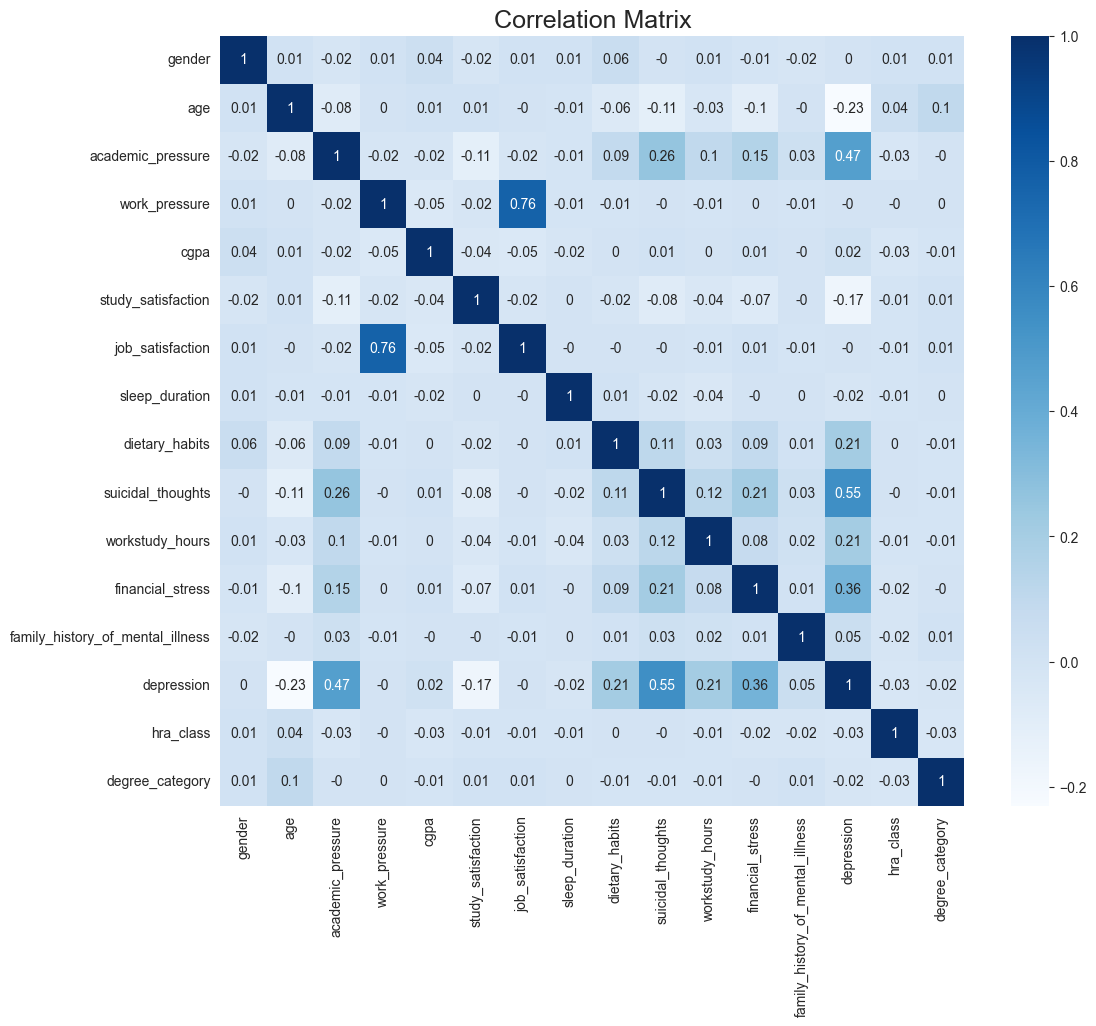

In [41]:
corr = round(df_encoded.corr(), 2)
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, annot=True, cmap='Blues')
plt.xticks(rotation=90)
plt.show()

Upon examining the correlation matrix, it was observed that `work_pressure` and `job_satisfaction` exhibited a very high correlation with each other **(r = 0.76)**, indicating strong multicollinearity. However, both features demonstrated negligible correlation with the target variable, `depression` **(r ≈ 0.00)**.
To avoid redundancy, reduce noise, and simplify the model, **both `work_pressure` and `job_satisfaction`** will be removed from the dataset. This will enable the model to focus on more relevant predictors while mitigating potential issues associated with multicollinearity.

In [42]:
df_encoded = df_encoded.drop(columns=['work_pressure', 'job_satisfaction'], axis=1)

In [43]:
df_encoded.dtypes

gender                              category
age                                    int64
academic_pressure                   category
cgpa                                 float64
study_satisfaction                  category
sleep_duration                      category
dietary_habits                      category
suicidal_thoughts                   category
workstudy_hours                        int64
financial_stress                    category
family_history_of_mental_illness    category
depression                          category
hra_class                           category
degree_category                     category
dtype: object

In [44]:
categorical_cols = df_encoded.select_dtypes(include=['category']).columns.drop(['depression'])
gender_dummies = pd.get_dummies(df_encoded['gender'], prefix='gender', drop_first=True, dtype='int')

In [45]:
other_categorical_cols = categorical_cols.drop(['gender'])

# separate binary and non-binary columns
binary_cols = [col for col in other_categorical_cols if df_encoded[col].nunique() == 2]
non_binary_cols = [col for col in other_categorical_cols if df_encoded[col].nunique() > 2]

# apply get_dummies separately
dummies_binary = pd.get_dummies(df_encoded[binary_cols], prefix=binary_cols, drop_first=True, dtype='int')
dummies_non_binary = pd.get_dummies(df_encoded[non_binary_cols], prefix=non_binary_cols, drop_first=False, dtype='int')

# combine
other_dummies = pd.concat([dummies_binary, dummies_non_binary], axis=1)
df_encoded_noncat = df_encoded.drop(columns=other_categorical_cols)

In [46]:
df_encoded_dummies = pd.concat([df_encoded_noncat, gender_dummies, other_dummies], axis=1)
df_encoded_dummies

,gender,age,cgpa,workstudy_hours,depression,gender_1,suicidal_thoughts_1,family_history_of_mental_illness_1,academic_pressure_0,academic_pressure_1,...,financial_stress_4,hra_class_0,hra_class_1,hra_class_2,degree_category_0,degree_category_1,degree_category_2,degree_category_3,degree_category_4,degree_category_5
0,1,33,8.97,3,1,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,24,5.90,3,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,31,7.03,9,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,28,5.59,4,1,0,1,1,0,0,...,1,0,1,0,1,0,0,0,0,0
4,0,25,8.13,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27,5.75,7,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
27897,1,27,9.40,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
27898,1,31,6.61,12,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
27899,0,18,6.88,10,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0


### Normalization

In [47]:
df_normalized = df_encoded_dummies.copy().astype(float)

In [48]:
features = df_normalized.drop(columns='depression')
target = df_normalized['depression']

In [49]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [50]:
df_normalized[features.columns] = features_scaled

In [51]:
df_normalized

,gender,age,cgpa,workstudy_hours,depression,gender_1,suicidal_thoughts_1,family_history_of_mental_illness_1,academic_pressure_0,academic_pressure_1,...,financial_stress_4,hra_class_0,hra_class_1,hra_class_2,degree_category_0,degree_category_1,degree_category_2,degree_category_3,degree_category_4,degree_category_5
0,1.0,0.365854,0.897,0.250000,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.146341,0.590,0.250000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.317073,0.703,0.750000,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.243902,0.559,0.333333,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.170732,0.813,0.083333,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0.0,0.219512,0.575,0.583333,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
27897,1.0,0.219512,0.940,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27898,1.0,0.317073,0.661,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27899,0.0,0.000000,0.688,0.833333,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Data Splitting

In [52]:
y = df_normalized['depression'].astype('int')
X = df_normalized.drop(columns=['depression'])

In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [54]:
X_train.columns

Index(['gender', 'age', 'cgpa', 'workstudy_hours', 'gender_1',
       'suicidal_thoughts_1', 'family_history_of_mental_illness_1',
       'academic_pressure_0', 'academic_pressure_1', 'academic_pressure_2',
       'academic_pressure_3', 'academic_pressure_4', 'academic_pressure_5',
       'study_satisfaction_0', 'study_satisfaction_1', 'study_satisfaction_2',
       'study_satisfaction_3', 'study_satisfaction_4', 'study_satisfaction_5',
       'sleep_duration_0', 'sleep_duration_1', 'sleep_duration_2',
       'sleep_duration_3', 'sleep_duration_4', 'dietary_habits_0',
       'dietary_habits_1', 'dietary_habits_2', 'dietary_habits_3',
       'financial_stress_0', 'financial_stress_1', 'financial_stress_2',
       'financial_stress_3', 'financial_stress_4', 'hra_class_0',
       'hra_class_1', 'hra_class_2', 'degree_category_0', 'degree_category_1',
       'degree_category_2', 'degree_category_3', 'degree_category_4',
       'degree_category_5'],
      dtype='object')

# Model Building

In [55]:
# Base learners
base_learners = [
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('nb', GaussianNB())
]

# Meta learners
meta_learners = {
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier(eval_metric='logloss')
}

# Prepare scoring
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'  # Use string name for built-in support
}

# Dictionary to store metrics for each model
all_metrics = {
    'Logistic Regression': {},
    'Random Forest': {},
    'XGBoost': {}
}

In [56]:
# print("\nTraining stacking model with meta-learner: Logistic Regression")
# clf_lr = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learners['LR'],
#     cv=5
# )
#
# metric_scores = {}
#
# for metric, score_func in scoring.items():
#     print(f"  Evaluating {metric}...")
#     scores = cross_val_score(clf_lr, X_train, y_train, cv=StratifiedKFold(5), scoring=score_func)
#     metric_scores[metric] = scores
#     print(f"    {metric} mean score: {np.mean(scores):.4f}")
#
# clf_lr.fit(X_train, y_train)
# all_metrics['Logistic Regression'] = metric_scores
# joblib.dump(clf_lr, 'stacking_model_lr.pkl')
# print("Finished training and evaluating model: Logistic Regression")

In [57]:
# print("\nTraining stacking model with meta-learner: Random Forest")
# clf_rf = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learners['RF'],
#     cv=5
# )
#
# metric_scores = {}
#
# for metric, score_func in scoring.items():
#     print(f"  Evaluating {metric}...")
#     scores = cross_val_score(clf_rf, X_train, y_train, cv=StratifiedKFold(5), scoring=score_func)
#     metric_scores[metric] = scores
#     print(f"    {metric} mean score: {np.mean(scores):.4f}")
#
# clf_rf.fit(X_train, y_train)
# all_metrics['Random Forest'] = metric_scores
# joblib.dump(clf_rf, 'stacking_model_rf.pkl')
# print("Finished training and evaluating model: Random Forest")

In [58]:
# print("\nTraining stacking model with meta-learner: XGBoost")
# clf_xgb = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learners['XGB'],
#     cv=5
# )
#
# metric_scores = {}
#
# for metric, score_func in scoring.items():
#     print(f"  Evaluating {metric}...")
#     scores = cross_val_score(clf_xgb, X_train, y_train, cv=StratifiedKFold(5), scoring=score_func)
#     metric_scores[metric] = scores
#     print(f"    {metric} mean score: {np.mean(scores):.4f}")
#
# clf_xgb.fit(X_train, y_train)
# all_metrics['XGBoost'] = metric_scores
# joblib.dump(clf_xgb, 'stacking_model_xgb.pkl')
# print("Finished training and evaluating model: XGBoost")

In [59]:
# metrics_df = pd.DataFrame(all_metrics).T
# metrics_df

In [60]:
# metrics_df.to_csv('model_metrics.csv', index=False)

In [61]:
metrics_df = pd.read_csv('model_metrics.csv')
metrics_df

,accuracy,precision,recall,f1,roc_auc
0,[0.84085297 0.84579125 0.83363269 0.85002245 0...,[0.85148148 0.85242291 0.84581171 0.85190563 0...,[0.88185654 0.89067894 0.87686997 0.90061397 0...,[0.86607647 0.87113112 0.86074995 0.87537313 0...,[0.91795918 0.91391475 0.9118819 0.91748168 0...
1,[0.82693603 0.82424242 0.81701841 0.82644814 0...,[0.83876946 0.8418271 0.83458084 0.84017758 0...,[0.87188339 0.85385501 0.85692367 0.87029931 0...,[0.85397898 0.84914286 0.84736145 0.85176825 0...,[0.89511723 0.89316631 0.89142067 0.89102778 0...
2,[0.84062851 0.83950617 0.82936686 0.83991917 0...,[0.84473398 0.85167286 0.84738806 0.84779412 0...,[0.88914461 0.87725355 0.87073264 0.88718342 0...,[0.86792453 0.86444529 0.85752079 0.86766355 0...,[0.912111 0.90887566 0.9040223 0.90742133 0...


In [62]:
# Columns to process
columns = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Fix formatting and compute mean manually
def parse_and_mean(s):
    # Remove brackets and split by whitespace
    nums = [float(x) for x in s.strip("[]").split()]
    return round(np.mean(nums), 3)

# Apply to each column
df_mean_format = pd.DataFrame({
    "model": ["lr", "rf", "xgb"],
    **{col: metrics_df[col].apply(parse_and_mean) for col in columns}
})

df_mean_format

,model,accuracy,precision,recall,f1,roc_auc
0,lr,0.842,0.850,0.887,0.868,0.915
1,rf,0.823,0.839,0.863,0.850,0.893
2,xgb,0.838,0.848,0.881,0.864,0.909


This table summarizes the performance of three stacking ensemble models with different meta-learners—Logistic Regression (lr), Random Forest (rf), and XGBoost (xgb) on a 5-fold cross validation.

**Logistic Regression (lr) performed best overall**, achieving the highest scores across all metrics of accuracy with 0.842, precision with 0.850, recall with 0.887, F1-score with 0.868, and ROC-AUC with 0.915. This indicates that the **lr-stacked model strikes a strong balance between correctly identifying both positive and negative cases of depression**. XGBoost (xgb) came in a close second, with particularly strong recall (0.881) and F1-score (0.864), suggesting that it's also very effective at identifying true positives (depressed cases) with minimal compromise in overall performance. Random Forest (rf) had the lowest metrics across the board, with a modest drop in accuracy (0.823) and ROC-AUC (0.893). While still competent, it may be slightly less robust in capturing subtle patterns within the ensemble setup.

In [63]:
clf_lr = joblib.load('stacking_model_lr.pkl')
clf_rf = joblib.load('stacking_model_rf.pkl')
clf_xgb = joblib.load('stacking_model_xgb.pkl')

## Test Set Metrics

In [64]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # for roc_auc
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("F1 Score:", round(f1_score(y_test, y_pred), 4))
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [65]:
evaluate_model('Logistic Regression', clf_lr, X_test, y_test)


=== Logistic Regression ===
Accuracy: 0.8449
Precision: 0.8559
Recall: 0.8837
F1 Score: 0.8696
ROC AUC: 0.9181

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      2310
           1       0.86      0.88      0.87      3259

    accuracy                           0.84      5569
   macro avg       0.84      0.84      0.84      5569
weighted avg       0.84      0.84      0.84      5569



The logistic regression stacking ensemble demonstrated strong generalization performance on the test set, achieving an accuracy of 84.49%. The model maintained high precision (0.8559) and recall (0.8837), resulting in a well-balanced F1 score of 0.8696. These metrics indicate that the model effectively identifies students at risk of depression while minimizing false positives. The ROC AUC score of 0.9181 further confirms the model’s strong discriminative capability between depressed and non-depressed classes. In terms of per-class performance, the model showed slightly lower recall for the non-depressed group (0.79), but it performed notably well in detecting depression cases, with a recall of 0.88. Overall, the model’s consistent performance across training and test sets highlights its reliability and practical applicability for real-world mental health screening among students.

In [66]:
evaluate_model('Random Forest', clf_rf, X_test, y_test)


=== Random Forest ===
Accuracy: 0.8271
Precision: 0.8462
Recall: 0.861
F1 Score: 0.8535
ROC AUC: 0.8971

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      2310
           1       0.85      0.86      0.85      3259

    accuracy                           0.83      5569
   macro avg       0.82      0.82      0.82      5569
weighted avg       0.83      0.83      0.83      5569



The random forest stacking ensemble achieved an accuracy of 82.71% on the test set, indicating solid performance in predicting student depression. With a precision of 0.8462 and a recall of 0.861, the model shows a strong ability to correctly identify true positive cases while keeping false positives relatively low. Its F1 score of 0.8535 reflects a good balance between precision and recall, and the ROC AUC score of 0.8971 suggests that the model maintains strong class separation capabilities. Looking at the classification report, the model performs slightly better on the depressed class (class 1), achieving a recall of 0.86 compared to 0.78 for the non-depressed class (class 0). This focus on accurately identifying depressed individuals aligns well with the objective of mental health screening. While its performance is slightly lower than that of the logistic regression model, the random forest ensemble still proves to be a reliable and effective approach for depression prediction.

In [67]:
evaluate_model('XGBoost', clf_xgb, X_test, y_test)


=== XGBoost ===
Accuracy: 0.8429
Precision: 0.8558
Recall: 0.8797
F1 Score: 0.8676
ROC AUC: 0.912

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      2310
           1       0.86      0.88      0.87      3259

    accuracy                           0.84      5569
   macro avg       0.84      0.84      0.84      5569
weighted avg       0.84      0.84      0.84      5569



The XGBoost stacking ensemble achieved an accuracy of 84.29% on the test set, closely matching the top-performing logistic regression model. With a precision of 0.8558 and recall of 0.8797, the model effectively identifies cases of depression while maintaining a low false positive rate. The resulting F1 score of 0.8676 confirms a strong balance between sensitivity and specificity. Its ROC AUC score of 0.912 further indicates excellent discriminatory power between depressed and non-depressed students. Per the classification report, the model performs slightly better on the depressed class (class 1), with a recall of 0.88 and precision of 0.86, suggesting its strength in correctly flagging at-risk individuals. Though the non-depressed group shows marginally lower recall (0.79), the model still maintains balanced overall performance. These results highlight XGBoost as a robust and highly competitive meta-learner for the stacking ensemble in the context of student mental health prediction.

## Feature Importance

In [68]:
model = clf_lr

In [69]:
X_train_small = shap.utils.sample(X_train, 100, random_state=SEED)

In [70]:
# X_meta = model.transform(X_train)
#
# X_meta_small = shap.utils.sample(X_meta, 100, random_state=42)
#
# try:
#     explainer_meta = shap.TreeExplainer(model.final_estimator_)
# except:
#     explainer_meta = shap.Explainer(model.final_estimator_, X_meta_small)

In [71]:
# shap_values_meta = explainer_meta(X_meta_small)

In [72]:
# shap.summary_plot(shap_values_meta, X_meta_small, feature_names=['SVM', 'KNN', 'Naive Bayes'], plot_type="bar")

**Limitation of Stacking Ensembles**

It is an inherent limitation of Stacking Ensemble methods to lose interpretability, as seen here, the shap values are assigned to the base learners of the Logistic Regression. Thus, for the sake of finding the importance of each feature, we will retrain the SVM model which has the highest impact on the Logistic Regression's predictions. In this case, it is the SVM with the highest impact.

In [73]:
# svm_model = SVC(probability=True, random_state=SEED)

In [74]:
# svm_model.fit(X_train, y_train)

In [75]:
# y_pred = model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# print(classification_report(y_pred, y_test))

In [76]:
# result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=SEED)

In [77]:
# # Sort features by importance
# sorted_idx = result.importances_mean.argsort()[::-1]
# top_n = 10
# top_idx = sorted_idx[:top_n]
# feature_names = np.array(X_test.columns)

# # Plot top 10 features
# plt.figure(figsize=(10, 6))
# plt.barh(
#     range(top_n),
#     result.importances_mean[top_idx],
#     xerr=result.importances_std[top_idx],
#     align="center"
# )
# plt.yticks(range(top_n), feature_names[top_idx])
# plt.xlabel("Mean Decrease in Accuracy")
# plt.title("Top 10 Permutation Feature Importances (SVM)")
# plt.gca().invert_yaxis()  # Most important at the top
# plt.tight_layout()
# plt.show()

## Recommendations

Based on the results of this analysis, it is evident that both educators and students have vital roles to play in addressing the student mental health crisis. Using a supervised machine learning approach with over 27,000 student records, the study identified suicidal thoughts and academic pressure as the top predictors of depression. Among these, suicidal ideation emerged as the most influential feature, with the greatest mean decrease in model accuracy when permuted. This behavior highlights its critical role in depression risk. Close behind were certain levels of academic pressure, particularly those representing low (academic_pressure_1) and high (academic_pressure_5) ends of the scale. These findings validate the urgent need for proactive mental health interventions within academic settings.

For educators, these results highlight the importance of recognizing academic pressure as a serious risk factor—not merely a common student experience. Faculty members and academic advisers are encouraged to open regular conversations about well-being, monitor signs of withdrawal or burnout, and normalize mental health check-ins during advisory sessions. Institutionalizing wellness checks and embedding them into academic advisories could serve as low-cost, scalable interventions. These simple but meaningful actions align directly with the data, which show that pressure within the academic system is not benign but predictive of psychological distress.

Students, on the other hand, are reminded that overwhelming feelings of hopelessness or exhaustion are not to be dismissed. If such feelings arise, seeking help early is essential. The data-driven model reveals that students who reported suicidal thoughts were significantly more likely to also screen positive for depression, more so than any other feature in the dataset. This reinforces the recommendation to take suicidal ideation seriously and to reach out for support when needed. Furthermore, lifestyle factors such as sleep deprivation, poor nutrition, and excessive study hours also contributed to depressive symptoms, although to a lesser extent. Students are encouraged to strive for balance across sleep, nutrition, and social life, and to remember that asking for help is not a weakness but a courageous and necessary step toward wellness.

This study's findings emphasize that effective mental health prevention is a shared responsibility. Educators must foster safe academic spaces, while students must be empowered to prioritize their mental well-being. Machine learning has shown us where the most critical risk indicators lie, it is now up to our institutions and communities to translate these insights into meaningful action.

# References

* Bordey, H. (2024, October 1). CHED: More college students cited mental health as reason for dropping out. GMA News Online. https://www.gmanetwork.com/news/topstories/nation/922218/ched-more-college-students-cited-mental-health-as-reason-for-dropping-out/story/
* Choudhury, A. A., Khan, M. R. H., Nahim, N. Z., Tulon, S. R., Islam, S., & Chakrabarty, A. (2019). Predicting Depression in Bangladeshi Undergraduates using Machine Learning. 2017 IEEE Region 10 Symposium (TENSYMP). https://doi.org/10.1109/tensymp46218.2019.8971369
* Iparraguirre-Villanueva, O., Paulino-Moreno, C., Epifanía-Huerta, A., & Torres-Ceclén, C. (2024). Machine learning models to classify and predict depression in college students. International Journal of Interactive Mobile Technologies (iJIM), 18(14), 148–163. https://doi.org/10.3991/ijim.v18i14.48669
* Felipe, C. S. (2023, January 31). Student suicides on the rise – DepEd. Philstar.com. https://www.philstar.com/headlines/2023/02/01/2241662/student-suicides-rise-deped
* Vergaray, A. D., Miranda, J. C. H., Cornelio, J. B., Carranza, A. R. L., & Sánchez, C. F. P. (2023). Predicting the depression in university students using stacking ensemble techniques over oversampling method. Informatics in Medicine Unlocked, 41, 101295. https://doi.org/10.1016/j.imu.2023.101295
* Vu, T., Dawadi, R., Yamamoto, M., Tay, J. T., Watanabe, N., Kuriya, Y., Oya, A., Tran, P. N. H., & Araki, M. (2025). Prediction of depressive disorder using machine learning approaches: findings from the NHANES. BMC Medical Informatics and Decision Making, 25(1). https://doi.org/10.1186/s12911-025-02903-1

# Prediction

For example, a new record is in a txt file:

```
Gender: Male
Age: 21
Academic Pressure: 3
CGPA: 8.5
Study Satisfaction: 4
Sleep Duration: '5-6 hours'
Dietary Habits: Healthy
Suicidal Thoughts: No
Work/Study Hours: 6
Financial Stress: 3
Family History of Mental Illness: Yes
HRA Class: Y
Degree Category: B
```

In [78]:
field_mapping = {
    'Gender': 'gender',
    'Age': 'age',
    'Academic Pressure': 'academic_pressure',
    'CGPA': 'cgpa',
    'Study Satisfaction': 'study_satisfaction',
    'Sleep Duration': 'sleep_duration',
    'Dietary Habits': 'dietary_habits',
    'Suicidal Thoughts': 'suicidal_thoughts',
    'Work/Study Hours': 'workstudy_hours',
    'Financial Stress': 'financial_stress',
    'Family History of Mental Illness': 'family_history_of_mental_illness',
    'HRA Class': 'hra_class',
    'Degree Category': 'degree_category'
}

In [79]:
new_record = {}
with open("record.txt", "r") as file:
    for line in file:
        if ":" in line:
            key, value = line.strip().split(":", 1)
            key = key.strip()
            value = value.strip()
            if key in field_mapping:
                col_name = field_mapping[key]
                try:
                    new_record[col_name] = eval(value)  # convert numeric values or quoted strings
                except:
                    new_record[col_name] = value

new_df = pd.DataFrame([new_record])

In [80]:
new_df

,gender,age,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,suicidal_thoughts,workstudy_hours,financial_stress,family_history_of_mental_illness,hra_class,degree_category
0,Male,21,3,8.5,4,5-6 hours,Healthy,No,6,3,Yes,Y,B


The new data has to undergo the same cleaning pipeline as `X_train`

In [81]:
cat_cols = [
    'gender',
    'academic_pressure',
    'study_satisfaction',
    'sleep_duration',
    'dietary_habits',
    'suicidal_thoughts',
    'financial_stress',
    'family_history_of_mental_illness',
    'hra_class',
    'degree_category',
]

new_df[cat_cols] = new_df[cat_cols].astype('category')

In [82]:
label_mappings = {
    'gender': {'Female': 0, 'Male': 1},
    'academic_pressure': {str(i): i for i in range(6)},
    'study_satisfaction': {str(i): i for i in range(6)},
    'sleep_duration': {
        "'5-6 hours'": 0, "'7-8 hours'": 1, "'Less than 5 hours'": 2,
        "'More than 8 hours'": 3, 'Others': 4
    },
    'dietary_habits': {'Healthy': 0, 'Moderate': 1, 'Others': 2, 'Unhealthy': 3},
    'suicidal_thoughts': {'No': 0, 'Yes': 1},
    'financial_stress': {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4},
    'family_history_of_mental_illness': {'No': 0, 'Yes': 1},
    'hra_class': {'X': 0, 'Y': 1, 'Z': 2},
    'degree_category': {'B': 0, 'HS': 1, 'M': 2, 'MD': 3, 'Others': 4, 'PhD': 5}
}

for col, mapping in label_mappings.items():
    new_df[col] = new_df[col].map(mapping).astype('category')

In [83]:
# binary and non-binary separation
binary_cols = ['suicidal_thoughts', 'family_history_of_mental_illness']
non_binary_cols = ['academic_pressure', 'study_satisfaction', 'sleep_duration',
                   'dietary_habits', 'financial_stress', 'hra_class', 'degree_category']

# Dummy encoding
dummies_binary = pd.get_dummies(new_df[binary_cols], prefix=binary_cols, drop_first=True, dtype='int')
dummies_non_binary = pd.get_dummies(new_df[non_binary_cols], prefix=non_binary_cols, drop_first=False, dtype='int')
gender_dummies = pd.get_dummies(new_df['gender'], prefix='gender', drop_first=True, dtype='int')

# Combine
other_dummies = pd.concat([dummies_binary, dummies_non_binary], axis=1)
numerical = new_df[['age', 'cgpa', 'workstudy_hours']]
processed_df = pd.concat([numerical, gender_dummies, other_dummies], axis=1)

In [84]:
processed_df = processed_df.reindex(columns=X_train.columns, fill_value=0).astype('float')
processed_df

,gender,age,cgpa,workstudy_hours,gender_1,suicidal_thoughts_1,family_history_of_mental_illness_1,academic_pressure_0,academic_pressure_1,academic_pressure_2,...,financial_stress_4,hra_class_0,hra_class_1,hra_class_2,degree_category_0,degree_category_1,degree_category_2,degree_category_3,degree_category_4,degree_category_5
0,0.0,21.0,8.5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [85]:
processed_df[:] = scaler.transform(processed_df)

In [86]:
print(processed_df.iloc[0])

gender                                0.000000
age                                   0.073171
cgpa                                  0.850000
workstudy_hours                       0.500000
gender_1                              0.000000
suicidal_thoughts_1                   0.000000
family_history_of_mental_illness_1    0.000000
academic_pressure_0                   0.000000
academic_pressure_1                   0.000000
academic_pressure_2                   0.000000
academic_pressure_3                   0.000000
academic_pressure_4                   0.000000
academic_pressure_5                   0.000000
study_satisfaction_0                  0.000000
study_satisfaction_1                  0.000000
study_satisfaction_2                  0.000000
study_satisfaction_3                  0.000000
study_satisfaction_4                  0.000000
study_satisfaction_5                  0.000000
sleep_duration_0                      0.000000
sleep_duration_1                      0.000000
sleep_duratio

## Make Prediction

In [87]:
prediction = clf_lr.predict(processed_df)
probability = clf_lr.predict_proba(processed_df)[0][1]

print("Predicted Depression:", "Yes" if prediction == 1 else "No")
print("Probability of Depression:", round(probability, 3))

Predicted Depression: No
Probability of Depression: 0.101
